# <p style="text-align:center;">**House selling prediction** - **Data Analysis**</p>

---

In this machine learning task, the main focus will be to predict whether or not a user will buy a house from a real estate website based on their profile: **gender**, **annual income**, **time on the website**, **age**, and whether any **ads** were clicked by the user. Therefore, the real goal is to analyze a dataset with **different types of predictor variables** and develop a model capable of **identifying patterns** and **generalizing outcomes** directly from the data.

This task, in a scenario applied to the **real world** context, can improve the conversion of clicks on a real website to **increase sales rates**, identifying the **most profitable user profile** and directing attention to it.

In [1]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
import scipy.stats as stats

In [2]:
# Constans and start settings.
TEST_SIZE = 0.33
RANDOM_STATE = 42

sns.set_style("whitegrid", {"grid.color": ".92", "grid.linestyle": "--"})
plt.rc("axes.spines", top=False, right=False)

## First contact with the dataset.

---

In [3]:
house_sell_df = pd.read_csv("dataset.csv")

house_sell_df.shape

(200, 6)

* The dataset contains 200 tuples, which is not considered a huge dataset in a real word scenario, however, as better way to analyze a dataset size is the **ratio bettween the features number**, the number to consider is:

$$
\frac{\#\_tuples}{\#\_features} = \frac{200}{5} = 40
$$

Which is a reasonable number to **simpler models**.

In [4]:
house_sell_df.head(10)

,Idade,Renda Anual (em $),Gênero,Tempo no Site (min),Anúncio Clicado,Compra (0 ou 1)
0,29.0,30000.0,Feminino,5.741706,Não,0
1,58.0,50000.0,Feminino,21.885505,Sim,0
2,50.0,70000.0,Feminino,6.121339,Não,1
3,21.0,100000.0,Feminino,16.264925,Não,0
4,59.0,50000.0,Feminino,28.235667,Sim,1
5,24.0,70000.0,Feminino,9.130098,Sim,1
6,39.0,100000.0,Feminino,14.746809,Sim,1
7,50.0,100000.0,Masculino,23.246508,Não,0
8,34.0,30000.0,Masculino,27.056464,Sim,1
9,41.0,70000.0,Masculino,21.773575,Sim,0


* Based on the dataset's structure, there are **three *numerical* features** and **two *categorical* features**. The categorical features need to be **encoded** to make them suitable for use with modeling algorithms, as most machine learning models require numerical inputs.

Thus, the `LabelEncoder()` is used to encode the columns.

In [5]:
# Encode the gender variable with numbers.

filtered_df = house_sell_df.dropna(subset=['Gênero'])

encoder = LabelEncoder()
encoded_values = encoder.fit_transform(filtered_df['Gênero'])

house_sell_df.loc[filtered_df.index, 'Gênero'] = encoded_values

# Encode the clicked ad variable with numbers.

filtered_df = house_sell_df.dropna(subset=['Anúncio Clicado'])

encoder = LabelEncoder()
encoded_values = encoder.fit_transform(filtered_df['Anúncio Clicado'])

house_sell_df.loc[filtered_df.index, 'Anúncio Clicado'] = encoded_values

house_sell_df[['Gênero', 'Anúncio Clicado']] = house_sell_df[['Gênero', 'Anúncio Clicado']].astype('Int32')

To see the **dataset's balance**, the **class proportions** of the *target variable* are analyzed. This step is crucial for understanding how to handle the data and determining appropriate evaluation metrics. A simple unweighted accuracy metric may not be sufficient if the classes are imbalanced, as it could lead to **misleading results** and **overestimating models**, because of it's original proportions.

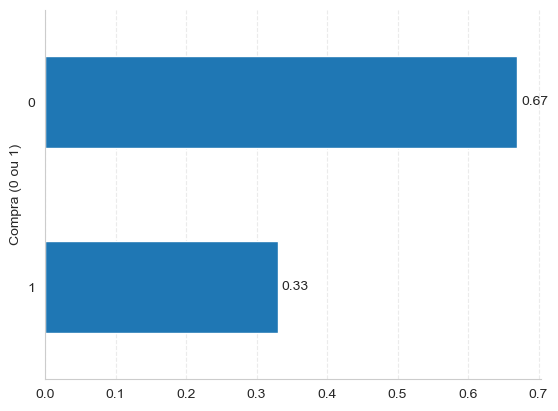

In [6]:
# Plot the normalized final label values counts to verify the dataset balancing.

ax = house_sell_df['Compra (0 ou 1)'].value_counts(normalize=True).sort_values().plot(kind='barh')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

sns.despine()
plt.grid(axis='y')
plt.show()

* According to the chart, the classes are imbalanced, with users who do not buy a house appearing twice as often as those who do.

* Given this imbalance, the model evaluation in this task will require **more precise metrics** to accurately reflect the model's performance and **generalization ability**, beyond simple accuracy, such as ***ROC-AUC*** or ***f1-score***.

Now, to undestand more deeply the data, the `describe()` method summaries some of the measures related to it.

## Verifying scales, inconsistencies and imputing.


---

In [7]:
house_sell_df.describe()

,Idade,Renda Anual (em $),Gênero,Tempo no Site (min),Anúncio Clicado,Compra (0 ou 1)
count,190.000000,189.000000,193.0,200.000000,190.0,200.000000
mean,38.510526,58253.968254,0.512953,17.349090,0.563158,0.330000
std,12.679918,25612.061811,0.501132,7.724088,0.497305,0.471393
min,18.000000,30000.000000,0.0,-1.000000,0.0,0.000000
25%,28.000000,30000.000000,0.0,10.860240,0.0,0.000000
50%,38.000000,50000.000000,1.0,18.197552,1.0,0.000000
75%,50.000000,70000.000000,1.0,23.887341,1.0,1.000000
max,59.000000,100000.000000,1.0,29.853484,1.0,1.000000


* It is clear that the columns have **different scales and distributions**, an aspect that will be addressed later.

According to the table, the variable `Tempo no Site (min)` ***(time on the website)*** contains **negative values**, which are inconsistent with the nature of the data. To fix this issue, these inconsistencies are replaced with `NaN` values for further handling.

In [8]:
# Replace negative values on 'Tempo no Site (min)' variable with NaN.

house_sell_df.loc[house_sell_df['Tempo no Site (min)'] < 0, 'Tempo no Site (min)'] = np.nan

house_sell_df.describe()

,Idade,Renda Anual (em $),Gênero,Tempo no Site (min),Anúncio Clicado,Compra (0 ou 1)
count,190.000000,189.000000,193.0,195.000000,190.0,200.000000
mean,38.510526,58253.968254,0.512953,17.819580,0.563158,0.330000
std,12.679918,25612.061811,0.501132,7.231815,0.497305,0.471393
min,18.000000,30000.000000,0.0,5.052596,0.0,0.000000
25%,28.000000,30000.000000,0.0,11.715915,0.0,0.000000
50%,38.000000,50000.000000,1.0,18.312317,1.0,0.000000
75%,50.000000,70000.000000,1.0,23.943929,1.0,1.000000
max,59.000000,100000.000000,1.0,29.853484,1.0,1.000000


To identify **duplicated tuples**, which could **negatively** impact the training phase and model accuracy, the dataset is analyzed using the `duplicated()` method.

In [9]:
house_sell_df.duplicated().sum()

0

* There are not duplicated rows.

In order to verify **null values** existent in the dataset, `isna()` method is applied.

In [10]:
house_sell_df.isna().sum()

Idade                  10
Renda Anual (em $)     11
Gênero                  7
Tempo no Site (min)     5
Anúncio Clicado        10
Compra (0 ou 1)         0
dtype: int64

* **There are null values**, which will be handled further.

To simulate **new data** in a **real deployment scenario**, the dataset is splitted into ***testing*** and ***training***.

In [11]:
# Create testing and training dataset to prevent from data leakage with 'stratify' to preserve the original proportions.
y = house_sell_df['Compra (0 ou 1)']

df_train, df_test = train_test_split(house_sell_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

df_train

,Idade,Renda Anual (em $),Gênero,Tempo no Site (min),Anúncio Clicado,Compra (0 ou 1)
43,21.0,70000.0,0,20.946927,0,0
122,NaN,50000.0,0,10.842802,0,0
21,27.0,30000.0,0,26.789943,1,0
146,37.0,50000.0,0,21.622793,0,0
7,50.0,100000.0,1,23.246508,0,0
...,...,...,...,...,...,...
117,29.0,70000.0,1,13.874908,0,0
12,58.0,50000.0,1,12.418191,1,1
34,57.0,70000.0,0,21.152404,0,1
4,59.0,50000.0,0,28.235667,1,1


To handle null values in categorical variables, a custom `KNNClassImputer` is implemented. This imputer identifies the **5 most similar tuples** in the dataset and imputes a value based on these rows. The imputed value is **rounded** to ensure it corresponds to a **valid class** on a ***discrete axis***.

In [12]:
# KNNImputer class customized to impute classes.
class KNNClassImputer(KNNImputer, TransformerMixin):
    def __init__(self, columns, n_neighbors=5, weights='uniform', metric='nan_euclidean'):
        self.columns = columns
        self.imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights, metric=metric)
    
    def fit(self, X, y=None):
        self.imputer.fit(X[self.columns])
        return self
    
    def transform(self, X):
        X_imputed = X.copy()
        imputed_values = self.imputer.transform(X[self.columns])
        imputed_values = np.round(imputed_values)
        X_imputed[self.columns] = imputed_values
        return X_imputed

The complete preprocessing pipeline consists of imputing missing categorical values using `knn_categorical` and handling the rest of the dataset with `knn_numerical`.

To prevent **data leakage** from the testing dataset and to avoid **potential bias in the models**, the pipeline is fitted **exclusively on the training dataset**.

In [13]:
# Preprocessing pipeline applied on data.
pipeline = Pipeline([
    ('knn_categorical', KNNClassImputer(columns=['Gênero', 'Anúncio Clicado'], weights='distance')),
    ('knn_numerical', KNNImputer(n_neighbors=5, weights='distance'))
])

# Apply on every column in the datasets except for the target variable.
df_train.iloc[:, :-1] = pipeline.fit_transform(df_train.iloc[:, :-1])
df_test.iloc[:, :-1] = pipeline.transform(df_test.iloc[:, :-1])

## Exploratory Data Analysis.

---

To visually explore the variables' **distributions** and their **correlations** on graphs, the `scatter_matrix()` function is used.

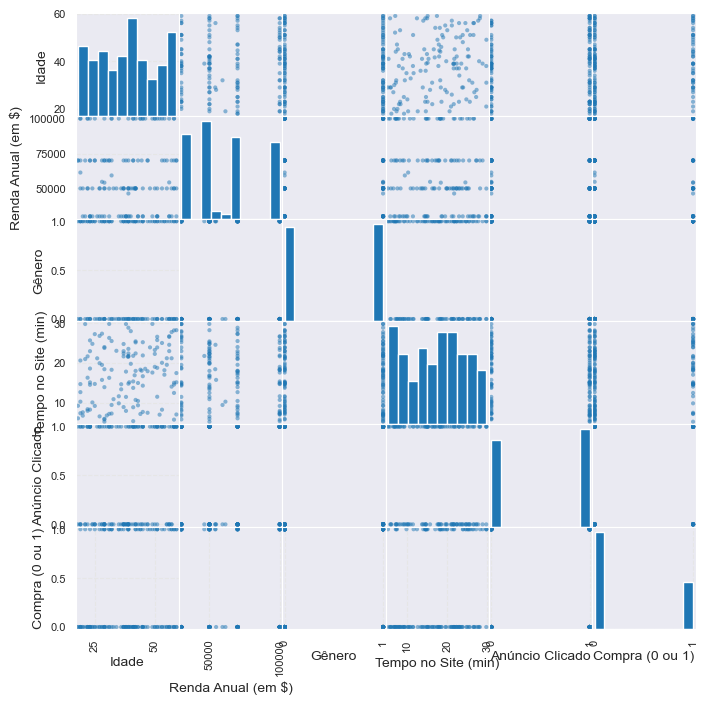

In [14]:
# Plot space correlation and histograms for every feature in the dataset.
with sns.axes_style("darkgrid", {"grid.color": ".9", "grid.linestyle": "--"}):
    pd.plotting.scatter_matrix(df_train, diagonal='hist', figsize=(8, 8))

plt.show()

* Based on the chart, the discrete variables do not exhibit significant imbalance, as their proportions appear **relatively similar**.

* Although there are some exceptions, the `Renda Anual (em $)` (Annual Income) column predominantly displays values on a **discrete scale**, grouped into three to four distinct ranges. This pattern suggests a potential **conversion to categorical income ranges** for better **interpretability and analysis**.

* The distributions of the continuous variables differ significantly from a ***Gaussian distribution***, suggesting that **non-parametric methods** may be more appropriate for this dataset.

To discretize the `Renda Anual (em $)` (Annual Income), `KBinsDiscretizer` is used.

In [15]:
# Discretize the annual income feature due to it's similarity to a discrete scale.
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

df_train['Renda Anual (em $)'] = discretizer.fit_transform(df_train[['Renda Anual (em $)']])
df_test['Renda Anual (em $)'] = discretizer.transform(df_test[['Renda Anual (em $)']])

# Verify the classes.
df_train['Renda Anual (em $)'].unique()

array([2., 1., 0.])

To quantify the **mathematical correlation** between variables, the ***Pearson correlation heatmap*** is used. This helps identify any numerical proportionalities or linear relationships between the features.

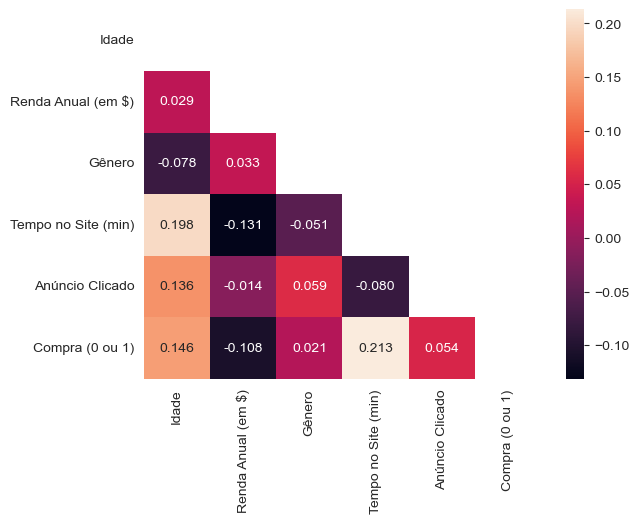

In [16]:
# Plot Pearson correlation on a heatmap.
pearson_correlation = df_train.corr()

sns.heatmap(pearson_correlation, annot=True, fmt='.3f', mask=np.triu(pearson_correlation))

plt.grid(False)
plt.show()

* According to the Pearson correlation, `Tempo no Site (min)` (Time on the Website) is the most correlated feature with the **target variable**, followed by `Idade` (Age) as the second most correlated, suggesting a potential **semantic relationship**. Additionally, the `Renda Anual (em $)` (Annual Income) column exhibits the **most negative correlation**, indicating an **inverse proportionality with the target variable**.

* The predictor variable does not show a high correlation degree between eachother, with `Tempo no Site (min)` and `Idade` as the most correlated ones. This suggest that most of the features are **not redundant and potencially significant** to the prediction.

After, to evaluate the **impact of outliers** on correlations due to and to identify **potential non-linear relationships**, the ***Spearman correlation***, with a **rank analysis** between the values, is computed and visualized using a heatmap.

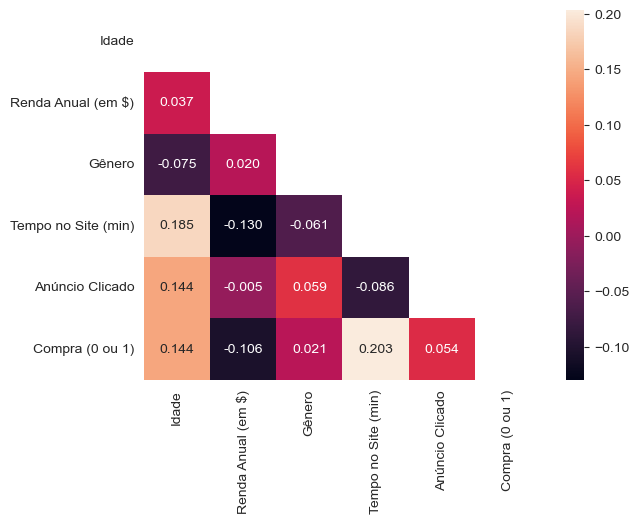

In [17]:
# Plot Spearman correlation on a heatmap.
spearman_correlation = df_train.corr(method='spearman')

sns.heatmap(spearman_correlation, annot=True, fmt='.3f', mask=np.triu(spearman_correlation))

plt.grid(False)
plt.show()

* Based on the chart, the high similarity between the two heatmaps suggests that **outliers do not have a significant impact** on the correlations. Additionally, the results indicate that **non-linear correlations are not particularly strong** in this dataset.

## Variables distributions.

---

Next, histograms for each variable are plotted to gain a **deeper understanding of their distributions**.

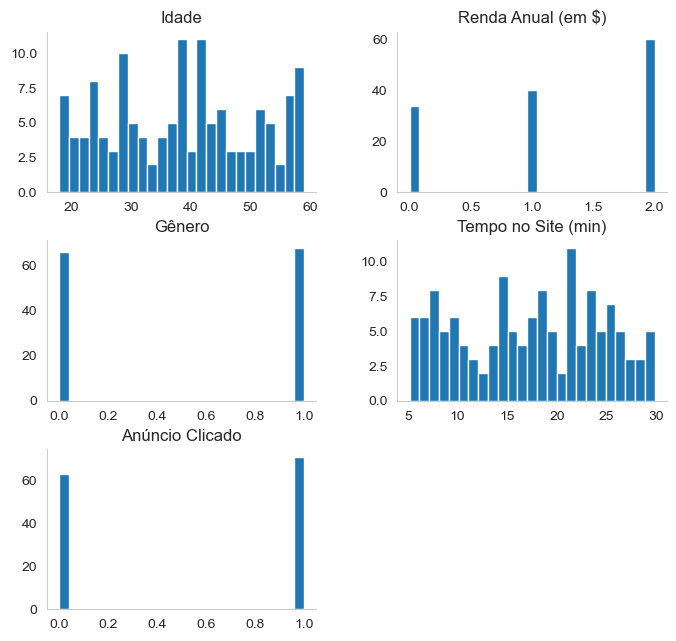

In [18]:
# Plot histograms for every featurein the dataset.
df_train.iloc[:, :-1].hist(grid=False, figsize=(8, 7.5), bins=25)

sns.despine()
plt.show()

* The continuous variables do not exhibit a clear resemblance to a normal distribution or any other well-known distribution.

* The `Gênero` (**Gender**) and `Anúncio Clicado` (**Ad Clicked**) columns show a relatively balanced distribution.

* The `Renda Anual (em $)` (**Annual Income**) column reveals a concentration pattern proportional to the income levels, suggesting a structured grouping in the data.

To analyze the remaining two continuous variables, the `scatterplot()` function is applied. The points are distinguished in the plot based on the target variable, allowing for a visual exploration of potential patterns or relationships.

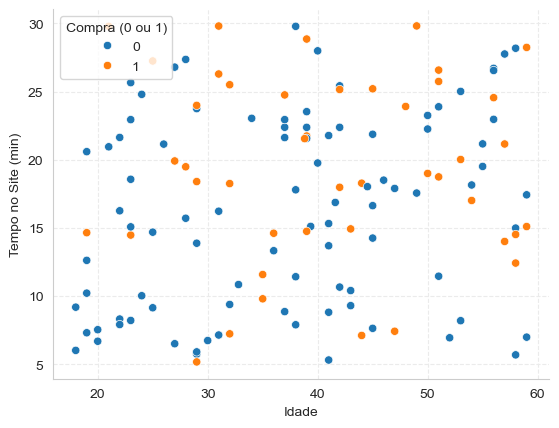

In [19]:
# Plot the scatterplot between time on the website and age, both continuous.
sns.scatterplot(data=df_train, x='Idade', y='Tempo no Site (min)', hue='Compra (0 ou 1)')

sns.despine()
plt.show()

* Based on the chart, there is **no clear segmentation of the final label** based on these two variables alone. This suggests that the **other variables may play a significant role** in the prediction and that a **more complex model** may be required to capture the underlying relationships.

To examine the continuous variable distributions in relation to the final label, the `kdeplot` function is utilized. This allows for a visual comparison of the density distributions for each label category.

In [20]:
# Funcion to plot the 'kdeplot' according to a feature a grouped by the final label.
def kdeplot_describe(column, data=df_train):
    sns.kdeplot(data=data, x=column, hue='Compra (0 ou 1)', common_norm=False)
    plt.title(f"KDE Plot for {column} by 'Compra (0 ou 1)'")
    sns.despine()
    plt.show()

    skewness = data.groupby('Compra (0 ou 1)')[column].apply(lambda x: stats.skew(x, nan_policy='omit'))
    kurtosis = data.groupby('Compra (0 ou 1)')[column].apply(lambda x: stats.kurtosis(x, nan_policy='omit'))
    
    print(data.groupby('Compra (0 ou 1)')[column].describe())
    print("\nSkewness by 'Compra (0 ou 1)':")
    print(skewness)
    print("\nKurtosis by 'Compra (0 ou 1)':")
    print(kurtosis)

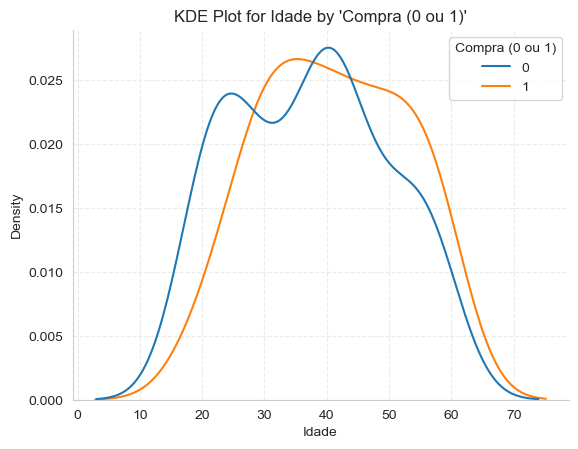

                 count       mean        std   min    25%   50%   75%   max
Compra (0 ou 1)                                                            
0                 90.0  37.280966  12.255179  18.0  26.25  38.0  45.0  59.0
1                 44.0  41.018507  11.492932  19.0  31.75  40.5  51.0  59.0

Skewness by 'Compra (0 ou 1)':
Compra (0 ou 1)
0    0.109184
1   -0.030199
Name: Idade, dtype: float64

Kurtosis by 'Compra (0 ou 1)':
Compra (0 ou 1)
0   -1.123415
1   -1.104013
Name: Idade, dtype: float64


In [21]:
kdeplot_describe(column='Idade')

* Based on the chart, there is a **dicrepancy among the age distribution** according with the relative label, which indicates a **potential relevant feature** to predict.

* The user who bought a house had a distribution where there is a later ascending curve and a later descending curve.

* Buyers have a slightly higher mean age (**41.02** vs. **37.28**) with similar ranges (**18 to 59**). Both groups show symmetric and flat distributions.

Now, to get a more precise measure of the distribution, the `QQplot` is used to compare the features's distribution with a gaussian.


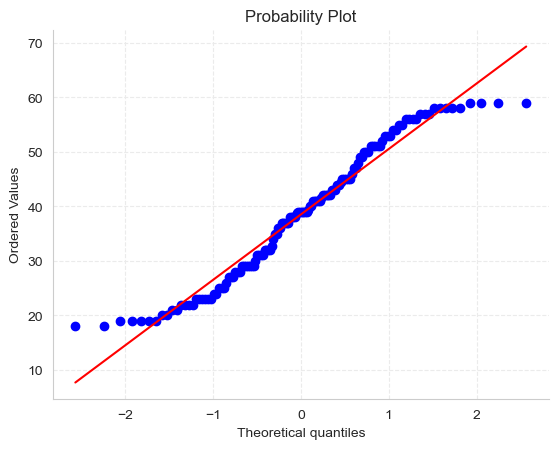

In [22]:
# Plot the Quartiles plot to verify similarity to the normal distribution.
stats.probplot(df_train['Idade'], dist="norm", plot=plt)

sns.despine()
plt.show()

* The chart indicates **no similarity** between the distributions based on the quartiles.

* The extended line edges sugges**t long-tailed distributio**ns, indicating values far from thmean.

To **reduce the discrepancies** between these distributions and achieve a closer alignment, the `log` function is applied to the data in an attempt to **normalize and improve similarity**. The logarithmic transformation was applied to reduce skewness, mitigate outliers, and normalize distributions. It helps compress extreme values, improve numerical stability, and enhance model performance. In this analysis, it was applied to variables like `Tempo no Site (min)` and `Renda Anual (em $)` to align their distributions for better interpretability and modeling...


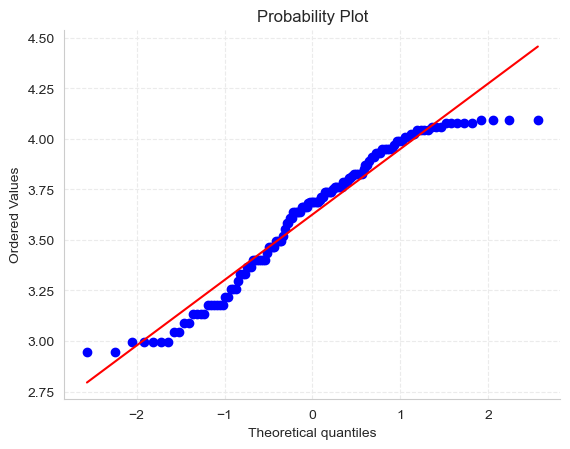

In [23]:
# Apply the log funciton to smooth the data.
df_train['Idade_log'] = df_train['Idade'].apply(lambda x: np.log(x + 1))

stats.probplot(df_train['Idade_log'], dist="norm", plot=plt)

sns.despine()
plt.show()

* The resulting distribution remains far from *Gaussian*, **strongly suggesting the rejection of parametric methods**.

Next, the `Tempo no Site (min)` variable is analyze.


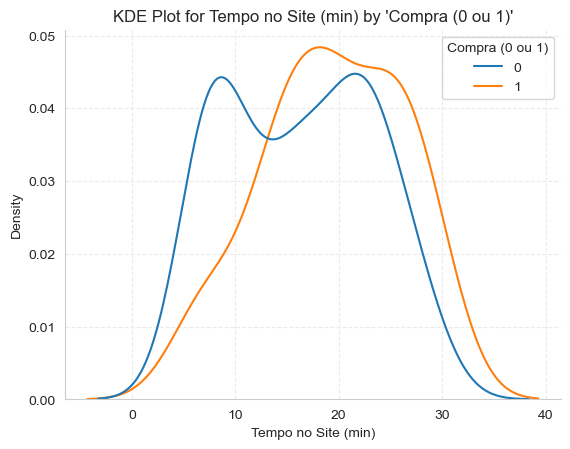

                 count       mean       std       min        25%        50%  \
Compra (0 ou 1)                                                               
0                 90.0  16.221973  7.042950  5.307743   9.212048  16.441612   
1                 44.0  19.422028  6.732322  5.167760  14.636645  19.236935   

                       75%        max  
Compra (0 ou 1)                        
0                22.341575  29.781581  
1                25.161243  29.812088  

Skewness by 'Compra (0 ou 1)':
Compra (0 ou 1)
0    0.042600
1   -0.272952
Name: Tempo no Site (min), dtype: float64

Kurtosis by 'Compra (0 ou 1)':
Compra (0 ou 1)
0   -1.287789
1   -0.785873
Name: Tempo no Site (min), dtype: float64


In [24]:
kdeplot_describe(column='Tempo no Site (min)')

* Based on the KDE plot, there is a noticeable difference in the distributions of `Tempo no Site (min)` between the two groups (`Compra = 0` and `Compra = 1`), indicating that this feature could be relevant for predicting the target.
* 
The users who purchased (`Compra = 1`) tend to have a slightly higher mean time on the site (**19.42 min** vs. **16.22 min**) and exhibit a distribution with a later peak and a longer tail. Both groups, however, share a similar range (**~5 to ~30 min**).**).

These differences high**light a potential association between the time spent on the site and the purchase **behavior. To further examine the distribut`ios, a` QQ plot can be used to compare the feature's distribution with a Gaussian distrbution.


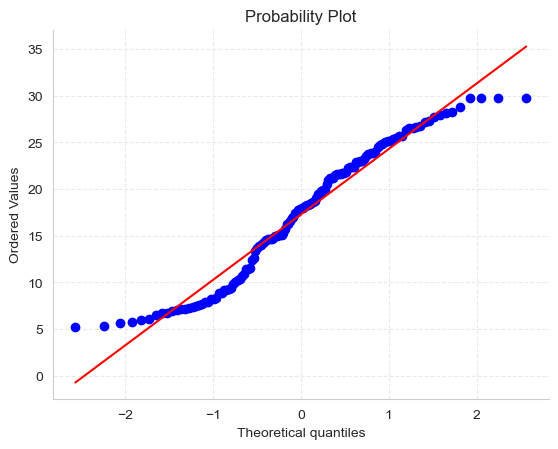

In [25]:
stats.probplot(df_train['Tempo no Site (min)'], dist="norm", plot=plt)

sns.despine()
plt.show()

* The `Tempo no Site (min)` variable shows no closer similarity to a normal distribution.

The logarithmic transformation is applied to attempt **a closer approximati**on to the Gaussian distributio.


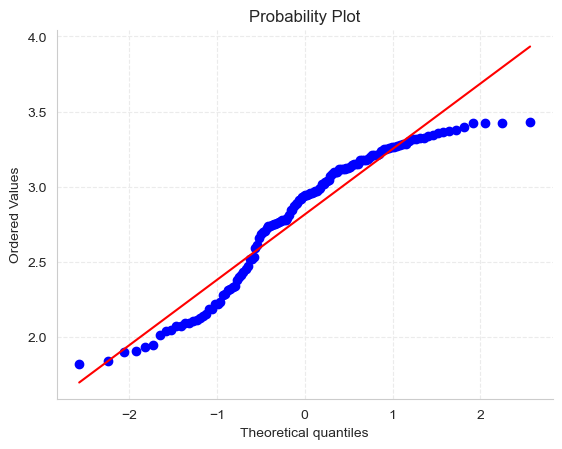

In [26]:
df_train['Tempo_log'] = df_train['Tempo no Site (min)'].apply(lambda x: np.log(x + 1))

stats.probplot(df_train['Tempo_log'], dist="norm", plot=plt)

sns.despine()
plt.show()

* There's still **no similarity between** the distributions and a Gaussian distribution.

Next, to analyze the categorical features, `barplots` are used to explore their association with the relative final label..


In [27]:
# Function to plot a 'barplot' on categorical features grouped by the final label.
def plot_bars(column):
    fig, ax = plt.subplots(figsize=(6, 5))
    
    counts_ads = df_train.groupby([column, 'Compra (0 ou 1)']).size().unstack(fill_value=0)
    counts_ads.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        legend=True,
        xlabel=column
    )
    
    for i, (_, row) in enumerate(counts_ads.iterrows()):
        total = row.sum()
        bottom = 0
        for j, value in enumerate(row):
            if value > 0:
                height = (value / total) * 100
                ax.text(
                    i, 
                    bottom + value / 2, 
                    f'{height:.1f}%', 
                    ha='center', 
                    va='center', 
                    fontsize=10
                )
                bottom += value
    
    sns.despine()
    plt.grid(axis='x')
    plt.show()

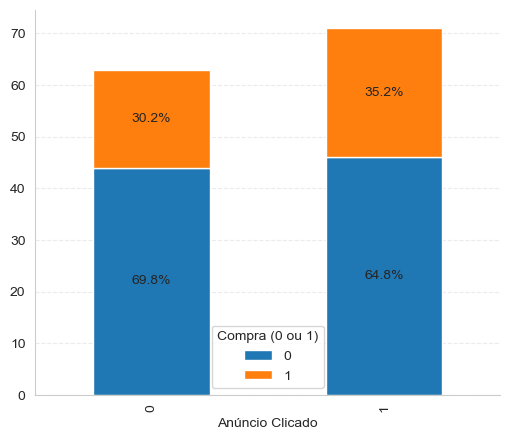

In [28]:
plot_bars('Anúncio Clicado')

* The `Anúncio Clicado` proportions across the final label suggest a **low correlation between clicking an ad and making a purchase**, **both bars close to the dataset's original proportion (67%-33%)**, with a **slightly higher likelihood of a sale if the user has clicked**.

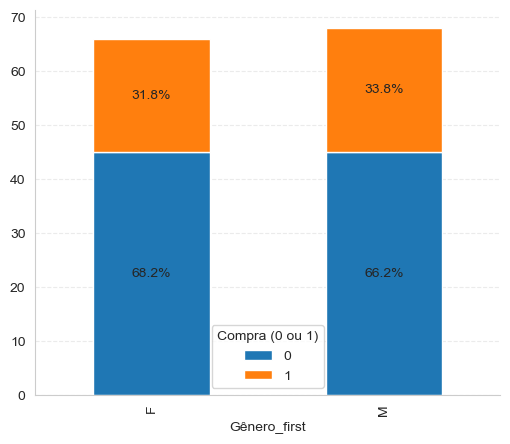

In [29]:
df_train['Gênero_first'] = df_train['Gênero'].apply(lambda x: 'M' if x == 1 else 'F')

plot_bars('Gênero_first')

* The `Gênero` column also indicates **low correlation according to the percentages**, **close to the original proportion**.

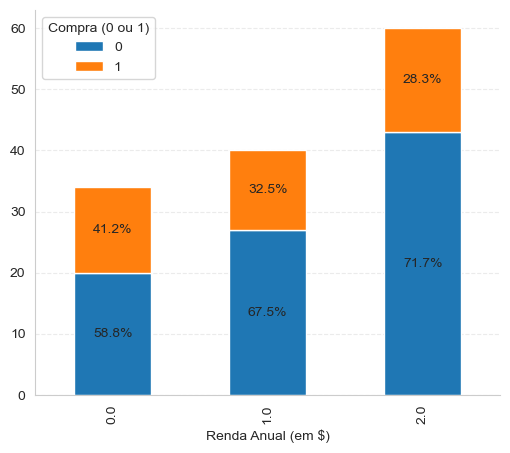

In [30]:
plot_bars('Renda Anual (em $)')

* The annual income variable bars suggest a stronger correlation with sales, indicating an **inverse proportionality** - the proportion of users who bought a house decreases as income increases.

## Saving

---

Now, the training and testing datasets are saved to be user on the modeling step.


In [31]:
# Keep only the original features.
interest_columns = ['Idade', 'Renda Anual (em $)', 'Gênero', 'Tempo no Site (min)', 'Anúncio Clicado', 'Compra (0 ou 1)']

# Save the dataframes.
df_train.to_csv('train.csv', columns=interest_columns, index=False)
df_test.to_csv('test.csv', columns=interest_columns, index=False)

## Conclusion

---

This notebook provided a thorough exploration and preparation of the dataset for future modeling tasks. Through exploratory data analysis, key insights were identified, such as the inverse relationship between annual income and purchase likelihood, as well as the potential significance of features like `Tempo no Site (min)`. Logarithmic transformations were applied to reduce skewness and mitigate the impact of outliers, improving data suitability for modeling. Categorical features were also analyzed, revealing slight associations with the target variable. Finally, the dataset was cleaned and relevant features were selected for training and testing, ensuring a robust foundation for machine learning implementation. The next steps involve applying predictive models, fine-tuning hyperparameters, and evaluating their performance to derive actionable insights.